In [481]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

## 1. Загрузка данных

In [482]:
athletes_df = pd.read_csv('./Data/athletes.csv')
athletes_df.head()

,id,name,nationality,sex,dob,height,weight,sport,gold,silver,bronze
0,736041664,A Jesus Garcia,ESP,male,10/17/69,1.72,64.0,athletics,0,0,0
1,532037425,A Lam Shin,KOR,female,9/23/86,1.68,56.0,fencing,0,0,0
2,435962603,Aaron Brown,CAN,male,5/27/92,1.98,79.0,athletics,0,0,1
3,521041435,Aaron Cook,MDA,male,1/2/91,1.83,80.0,taekwondo,0,0,0
4,33922579,Aaron Gate,NZL,male,11/26/90,1.81,71.0,cycling,0,0,0


In [483]:
athletes_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11538 entries, 0 to 11537
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   id           11538 non-null  int64  
 1   name         11538 non-null  object 
 2   nationality  11538 non-null  object 
 3   sex          11538 non-null  object 
 4   dob          11537 non-null  object 
 5   height       11208 non-null  float64
 6   weight       10879 non-null  float64
 7   sport        11538 non-null  object 
 8   gold         11538 non-null  int64  
 9   silver       11538 non-null  int64  
 10  bronze       11538 non-null  int64  
dtypes: float64(2), int64(4), object(5)
memory usage: 991.7+ KB


> Мы видим пропуски в данных, у нас есть 1 пропуск по фиче dob, его можно просто удалить, height и weight можно заполнить средним значением

## 2. Обработка пропусков

### 2.1 Заполнение средним значением

In [484]:
athletes_df['height'] = athletes_df['height'].fillna(athletes_df['height'].mean())
athletes_df['weight'] = athletes_df['weight'].fillna(athletes_df['weight'].mean())

### 2.2 Удаление пропусков

In [485]:
athletes_df.dropna(inplace=True)

> Получился набор данных без пропусков:

In [486]:
athletes_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11537 entries, 0 to 11537
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   id           11537 non-null  int64  
 1   name         11537 non-null  object 
 2   nationality  11537 non-null  object 
 3   sex          11537 non-null  object 
 4   dob          11537 non-null  object 
 5   height       11537 non-null  float64
 6   weight       11537 non-null  float64
 7   sport        11537 non-null  object 
 8   gold         11537 non-null  int64  
 9   silver       11537 non-null  int64  
 10  bronze       11537 non-null  int64  
dtypes: float64(2), int64(4), object(5)
memory usage: 1.1+ MB


## 3. Кодировка категориальных переменных

В моей случае я буду предсказывать пол спортсмена(возьмем его как целевую переменную)

In [487]:
label_encoder = LabelEncoder()

In [488]:
athletes_df['sex_encoded'] = label_encoder.fit(athletes_df['sex']).transform(athletes_df['sex'])
athletes_df['sport_encoded'] = label_encoder.fit((athletes_df['sport'])).transform(athletes_df['sport'])
athletes_df['nationality_encoded'] = label_encoder.fit(athletes_df['nationality']).transform(athletes_df['nationality'])

## 4. Разделение данных на train и test

In [489]:
X = athletes_df.drop([
    'sex', 
    'sex_encoded', 
    'name', 
    'id',
    'sport',
    'nationality',
    'dob'
], axis=1)

y = athletes_df['sex_encoded']

In [490]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

## 5. Обучение модели логистической регрессии 

In [491]:
log_reg_model = LogisticRegression(max_iter=1000)
log_reg_model.fit(X_train, y_train)

LogisticRegression(max_iter=1000)

## 6. Построение ROC-AUC кривой и вычисление метрики

### 6.1 ROC-AUC кривая

In [492]:
y_predict_proba = log_reg_model.predict_proba(X_test)
y_true = y_test

In [493]:
fpr, tpr, thresholds = roc_curve(y_true, y_predict_proba[:, 1])

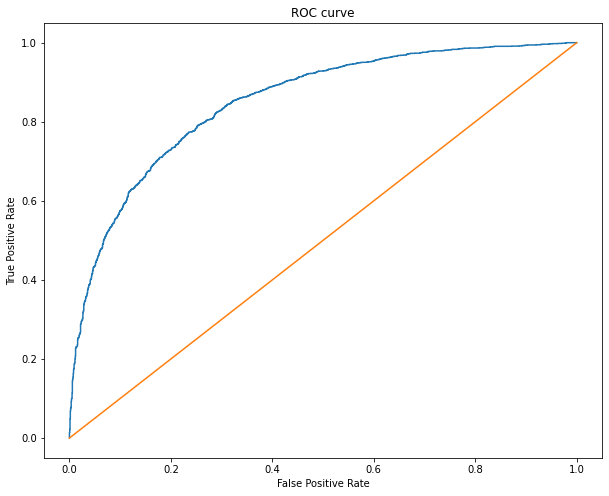

In [494]:
plt.figure(figsize=(10, 8))
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve')
plt.show()

### 6.2 ROC-AUC метрика

In [495]:
roc_auc_score(y_true, y_predict_proba[:, 1])

0.849818755692128

## 7. Реализация метрик TPR, FPR

### 7.1 Реализация True Positive Rate
$$TPR = TP/(TP+FN)$$ 

In [496]:
def true_positive_rate(y_true, y_predict_proba, thresholds):
    try:
        true_positive = 0
        false_negative = 0
        y_true = np.array(y_true)
        y_predict_proba = np.array(y_predict_proba)[:, 1]
    
        for actual, predict in zip(y_true, y_predict_proba):
            if predict >= thresholds:
                predicted = 1
            else:
                predicted = 0
            
            if predicted == 1:
                if actual == 1:
                    true_positive += 1
            else:
                if actual == 1:
                    false_negative += 1
                
        return true_positive / (true_positive + false_negative)
    except:
        return 0

### 7.2 Расчет метрики TPR

In [497]:
true_positive_rate(y_true, y_predict_proba,0.2)

0.9734939759036144

### 7.3 Реализация False Positive Rate

$$FPR = FP / (TN + FP)$$

In [498]:
def false_positive_rate(y_true, y_predict_proba, thresholds):
    try:
        true_negative = 0
        false_positive = 0
    
        y_true = np.array(y_true)
        y_predict_proba = np.array(y_predict_proba)[:, 1]
    
        for actual, predict in zip(y_true, y_predict_proba):
            predicted = 0
            if predict >= thresholds:
                predicted = 1
            else:
                predicted = 0
        
            if predicted == 1:
                if actual == 0:
                    false_positive += 1
            else:
                if actual == 0:
                    true_negative += 1
        return false_positive / (true_negative + false_positive)
    except:
        return 0

### 7.4 Расчет метрики FPR

In [499]:
false_positive_rate(y_true, y_predict_proba, 0.5)

0.2590882862088863

## 8. Построение ROC-AUC кривой с помощью наших метрик

In [500]:
def roc_auc_curve(y_true, y_predict_proba):
    THRESHOLDS_SIZE = len(y_true)
    
    thresholds = np.linspace(0, 1, THRESHOLDS_SIZE, 0.001)
    fpr = np.array([])
    tpr = np.array([])
    
    for threshold in thresholds:
        fpr = np.append(
            fpr,
            false_positive_rate(y_true, y_predict_proba, threshold)
        )
        
        tpr = np.append(
            tpr,
            true_positive_rate(y_true, y_predict_proba, threshold)
        )
        
    return fpr, tpr, thresholds

In [501]:
fpr_custom, tpr_custom, thresholds = roc_auc_curve(y_true, y_predict_proba)
fpr_sklearn, tpr_sklearn, thresholds = roc_curve(y_true, y_predict_proba[:, 1])

### 8.1 Сравнение графиков

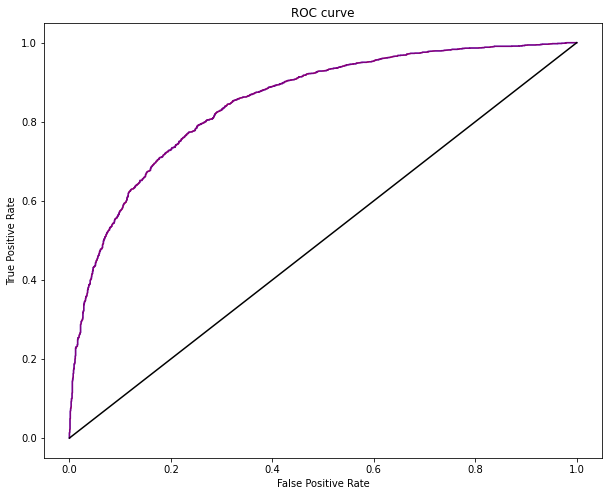

In [502]:
plt.figure(figsize=(10, 8))
plt.plot(fpr_custom, tpr_custom, color='blue')
plt.plot(fpr_sklearn, tpr_sklearn, color='red', alpha=0.5)
plt.plot([0, 1], [0, 1], color='black')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve')
plt.show()

> Мы видим, то что графики совпадают => график построен правильно.

> Модель показала хорошие результаты исходя из графика.

## 9. Построение графика Precision-Recall

In [503]:
def precision_recall_curve_show(y_true, y_predict_proba):
    SAMPLE_SIZE = len(y_true)
    
    recall_thresholds = np.linspace(1, 0, SAMPLE_SIZE, 0.001)
    precision_thresholds = np.linspace(0, 1, SAMPLE_SIZE, 0.001)
    
    y_true = np.array(y_true)
    y_predict_proba = np.array(y_predict_proba)
    
    recall_values = []
    precision_values = []
    for recall_threshold, precision_threshold in zip(recall_thresholds, precision_thresholds):
        recall_values.append(false_positive_rate(y_true, y_predict_proba, recall_threshold))
        precision_values.append(true_positive_rate(y_true, y_predict_proba, precision_threshold))
    
    plt.figure(figsize=(10, 8))
    plt.plot(recall_values, precision_values)
    plt.title('Precision-Recall')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.show()

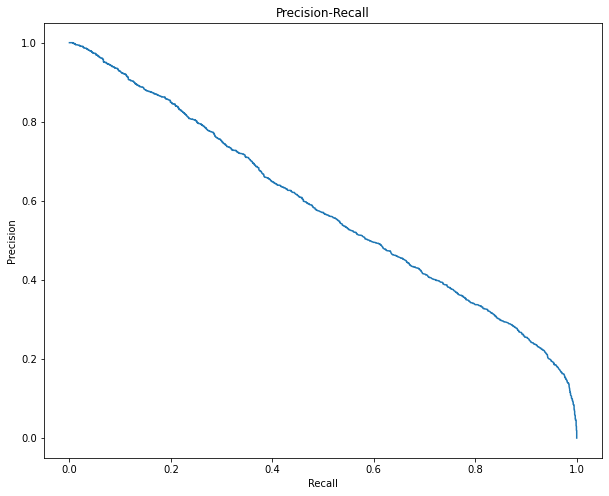

In [504]:
precision_recall_curve_show(y_true, y_predict_proba)

## Выводы

> Из этого графика Precision-Recall мы можем сделать вывод о том, что чем выше Precision, тем ниже Recall

> Из полученных графиков можно сделать выводы, что чем ближе кривая к верхнему левому углу, тем выше предсказательная способность модели(ROC-AUC curve)

> По нашим показателям графика ROC-AUC модель справилась нормально.